In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
import multiprocessing 
import pandas as pd
import pyLDAvis
import warnings
import seaborn
import pickle
import spacy
import time 
import os
import re

%matplotlib inline

## TF-IDF Analysis
- #### 1. Preprocessing
    - 1.1. HTML Parsing
    - 1.2. Lowercase 
    - 1.3. Lemmization
    - 1.4. Remove Stopwords, Numbers and Special Characters
    - 1.5. More Cleaning
    <br/><br/>
- #### 2. TF-IDF Analysis
    - 2.1. Unigrams
    - 2.2. Bigrams

In [2]:
pd.set_option('display.max_colwidth', 1000)

# Import our reports
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports.csv'
df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Year,School,Source,Report
0,Zach Wilson,2021,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...


## 1. Preprocessing
- 1.1. HTML Parsing
- 1.2. Lowercase 
- 1.3. Lemmization
- 1.4. Remove Stopwords, Numbers and Special Characters
- 1.5. More Cleaning

In [3]:
# Import spacy
nlp = spacy.load('en_core_web_sm')

# Define content words
content = {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'}

# Function to filter out HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Funtion to filter out the remaining tags
def remove_other_tags(text):
    text = re.sub(r'class=".*?"', '', text)
    text = re.sub(r'style=".*?"', '', text)
    text = re.sub(r'id=".*?"', '', text)
    text = re.sub(r'of-\d+', '', text)
    text = re.sub(r'\d+-', '', text)
    text = re.sub(r'\d+st', '', text)
    text = re.sub(r'\d+nd', '', text)
    text = re.sub(r'\d+rd', '', text)
    text = re.sub(r'\d+th', '', text)
    return text

# Function to preprocess our reports   
def clean(text):
    pattern = '^[^a-zA-Z0-9]'                   # RegEx to find special characters
    return ' '.join([token.lemma_               # Lemmization
        for token in nlp(text.lower())          # Split sentences into lowercase words
        if (token.pos_ in content) and          # Keep only "content" words
        (not re.match(pattern, token.lemma_))]) # Use the RegEx to filter out special characters      

# We create a new column for the preprocessed reports
df['Report_Cleaned'] = df['Report'].apply(remove_html_tags).apply(remove_other_tags).apply(clean)
df.head(5)

,Player,Year,School,Source,Report,Report_Cleaned
0,Zach Wilson,2021,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...,wilson runner up utah mr football award throw nearly yard touchdown corner canyon high school father mike play defensive tackle utah current ute head coach kyle whittingham then line coach already have quarterback recruit class so wilson sign arch rival byu start game play true freshman completion rate yard tds int pass tds rushing finish season famous idaho potato bowl mvp effort yard tds undergo right throw shoulder surgery season injury suffer high school start game yard tds int pass tds rushing miss time fractured right thumb require surgery wilson break share polynesian player year award usc safety talanoa hufanga rank second fbs completion percentage third pass touchdown just interception pass yard game total wilson also rush touchdown start cougar chad reuter ascend quarterback prospect possess swagger arm talent create explosive play pocket gunslinger mentality improvise release point clearly pattern favorite player aaron rodger however play little more reminiscent blend ja...
1,Zach Wilson,2021,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>,wilson lean quarterback good mobility arm strength play pistol heavy offense byu feature full field read mostly pro style concept good trait ability extend play have instinct agility create initial play break also do very good job adjust arm angle generate throw window ability throw receiver open also stand wilson show above average touch zone look appear have great top end speed s instinctive runner good quickness competitiveness wilson premier quarterback prospect mental physical tool excel nfl starter so long undersized frame hold final evaluation
2,Zach Wilson,2021,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst a

In [4]:
# Remove empty reports
df = df[df['Report_Cleaned'].notnull()]

# Make sure everything is a string
df['Report_Cleaned'] = df['Report_Cleaned'].apply(str)

In [5]:
path = 'dataset-quarterback_stats'
filename = 'census.csv'

# Import info about players ethnicity
df2 = pd.read_csv(os.path.join(path, filename))
df2.head(3)

,Player,Race
0,A.J. Feeley,White
1,A.J. McCarron,White
2,Aaron Brooks,Non-White


In [6]:
# Merge df and df2
df = df.merge(df2, how='left', on='Player')

In [9]:
df = df[['Player', 'Year', 'Race', 'School', 'Source', 'Report', 'Report_Cleaned']]
df.head(3)

,Player,Year,Race,School,Source,Report,Report_Cleaned
0,Zach Wilson,2021,White,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...,wilson runner up utah mr football award throw nearly yard touchdown corner canyon high school father mike play defensive tackle utah current ute head coach kyle whittingham then line coach already have quarterback recruit class so wilson sign arch rival byu start game play true freshman completion rate yard tds int pass tds rushing finish season famous idaho potato bowl mvp effort yard tds undergo right throw shoulder surgery season injury suffer high school start game yard tds int pass tds rushing miss time fractured right thumb require surgery wilson break share polynesian player year award usc safety talanoa hufanga rank second fbs completion percentage third pass touchdown just interception pass yard game total wilson also rush touchdown start cougar chad reuter ascend quarterback prospect possess swagger arm talent create explosive play pocket gunslinger mentality improvise release point clearly pattern favorite player aaron rodger however play little more reminiscent blend ja...
1,Zach Wilson,2021,White,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>,wilson lean quarterback good mobility arm strength play pistol heavy offense byu feature full field read mostly pro style concept good trait ability extend play have instinct agility create initial play break also do very good job adjust arm angle generate throw window ability throw receiver open also stand wilson show above average touch zone look appear have great top end speed s instinctive runner good quickness competitiveness wilson premier quarterback prospect mental physical tool excel nfl starter so long undersized frame hold final evaluation
2,Zach Wilson,2021,White,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the groun

In [10]:
checkpoint = '__checkpoints'
filename = 'reports_cleaned'

# Let's save a checkpoint of our dataframe
with open(os.path.join(checkpoint, filename + '.pkl'), 'wb') as f:
    pickle.dump(df, f)

In [2]:
checkpoint = '__checkpoints'
filename = 'reports_cleaned'

# Load our dataframe
with open(os.path.join(checkpoint, filename + '.pkl'), 'rb') as f:
    df = pickle.load(f)

In [3]:
# Split the dataset for white and non-white players
w = df[df['Race'] == 'White'].reset_index(drop=True)
nw = df[df['Race'] == 'Non-White'].reset_index(drop=True)

## 2. TF-IDF Analysis
- 2.1. Unigrams
- 2.2. Bigrams

In [4]:
w_docs = w['Report_Cleaned'].tolist()
nw_docs = nw['Report_Cleaned'].tolist()

### 2.1. Unigrams

In [42]:
# Set our parameters to filter out rare words (min_df) and the too common ones (max_df), we do not want to get flooded with non-informative content words (be, go, etc.)
min_df = 5
max_df = 1000

# TF-IDF and Count for unigrams 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df, sublinear_tf=True, use_idf=True)
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df)

In [54]:
# White players
X_count = count_vectorizer.fit_transform(w_docs)
X_tfidf = tfidf_vectorizer.fit_transform(w_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_w = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_w = df_w.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_w['relative_tf'] = df_w['tf'] * 100000 / df_w['tf'].sum()
df_w['relative_tfidf'] = df_w['tfidf'] * 100000 / df_w['tf'].sum()
df_w.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
1742,throw,1976,1.125015,27.878723,2288.387822,32.286099
135,ball,1252,1.250681,22.845170,1449.929935,26.456786
713,good,1165,1.168668,21.143546,1349.176018,24.486150
1200,pass,1038,1.324570,20.100457,1202.098461,23.278159
695,game,889,1.417735,19.385068,1029.542901,22.449673


In [55]:
# Non-White players
X_count = count_vectorizer.fit_transform(nw_docs)
X_tfidf = tfidf_vectorizer.fit_transform(nw_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_nw = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_nw = df_nw.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_nw['relative_tf'] = df_nw['tf'] * 100000 / df_nw['tf'].sum()
df_nw['relative_tfidf'] = df_nw['tfidf'] * 100000 / df_nw['tf'].sum()
df_nw.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
1093,throw,871,1.143512,12.296486,2336.812170,32.990331
88,ball,555,1.227162,10.365685,1489.013495,27.810170
607,make,460,1.168514,9.194486,1234.137311,24.667953
1200,yard,413,1.512610,8.917401,1108.040673,23.924559
826,quarterback,461,1.371296,8.916983,1236.820218,23.923437


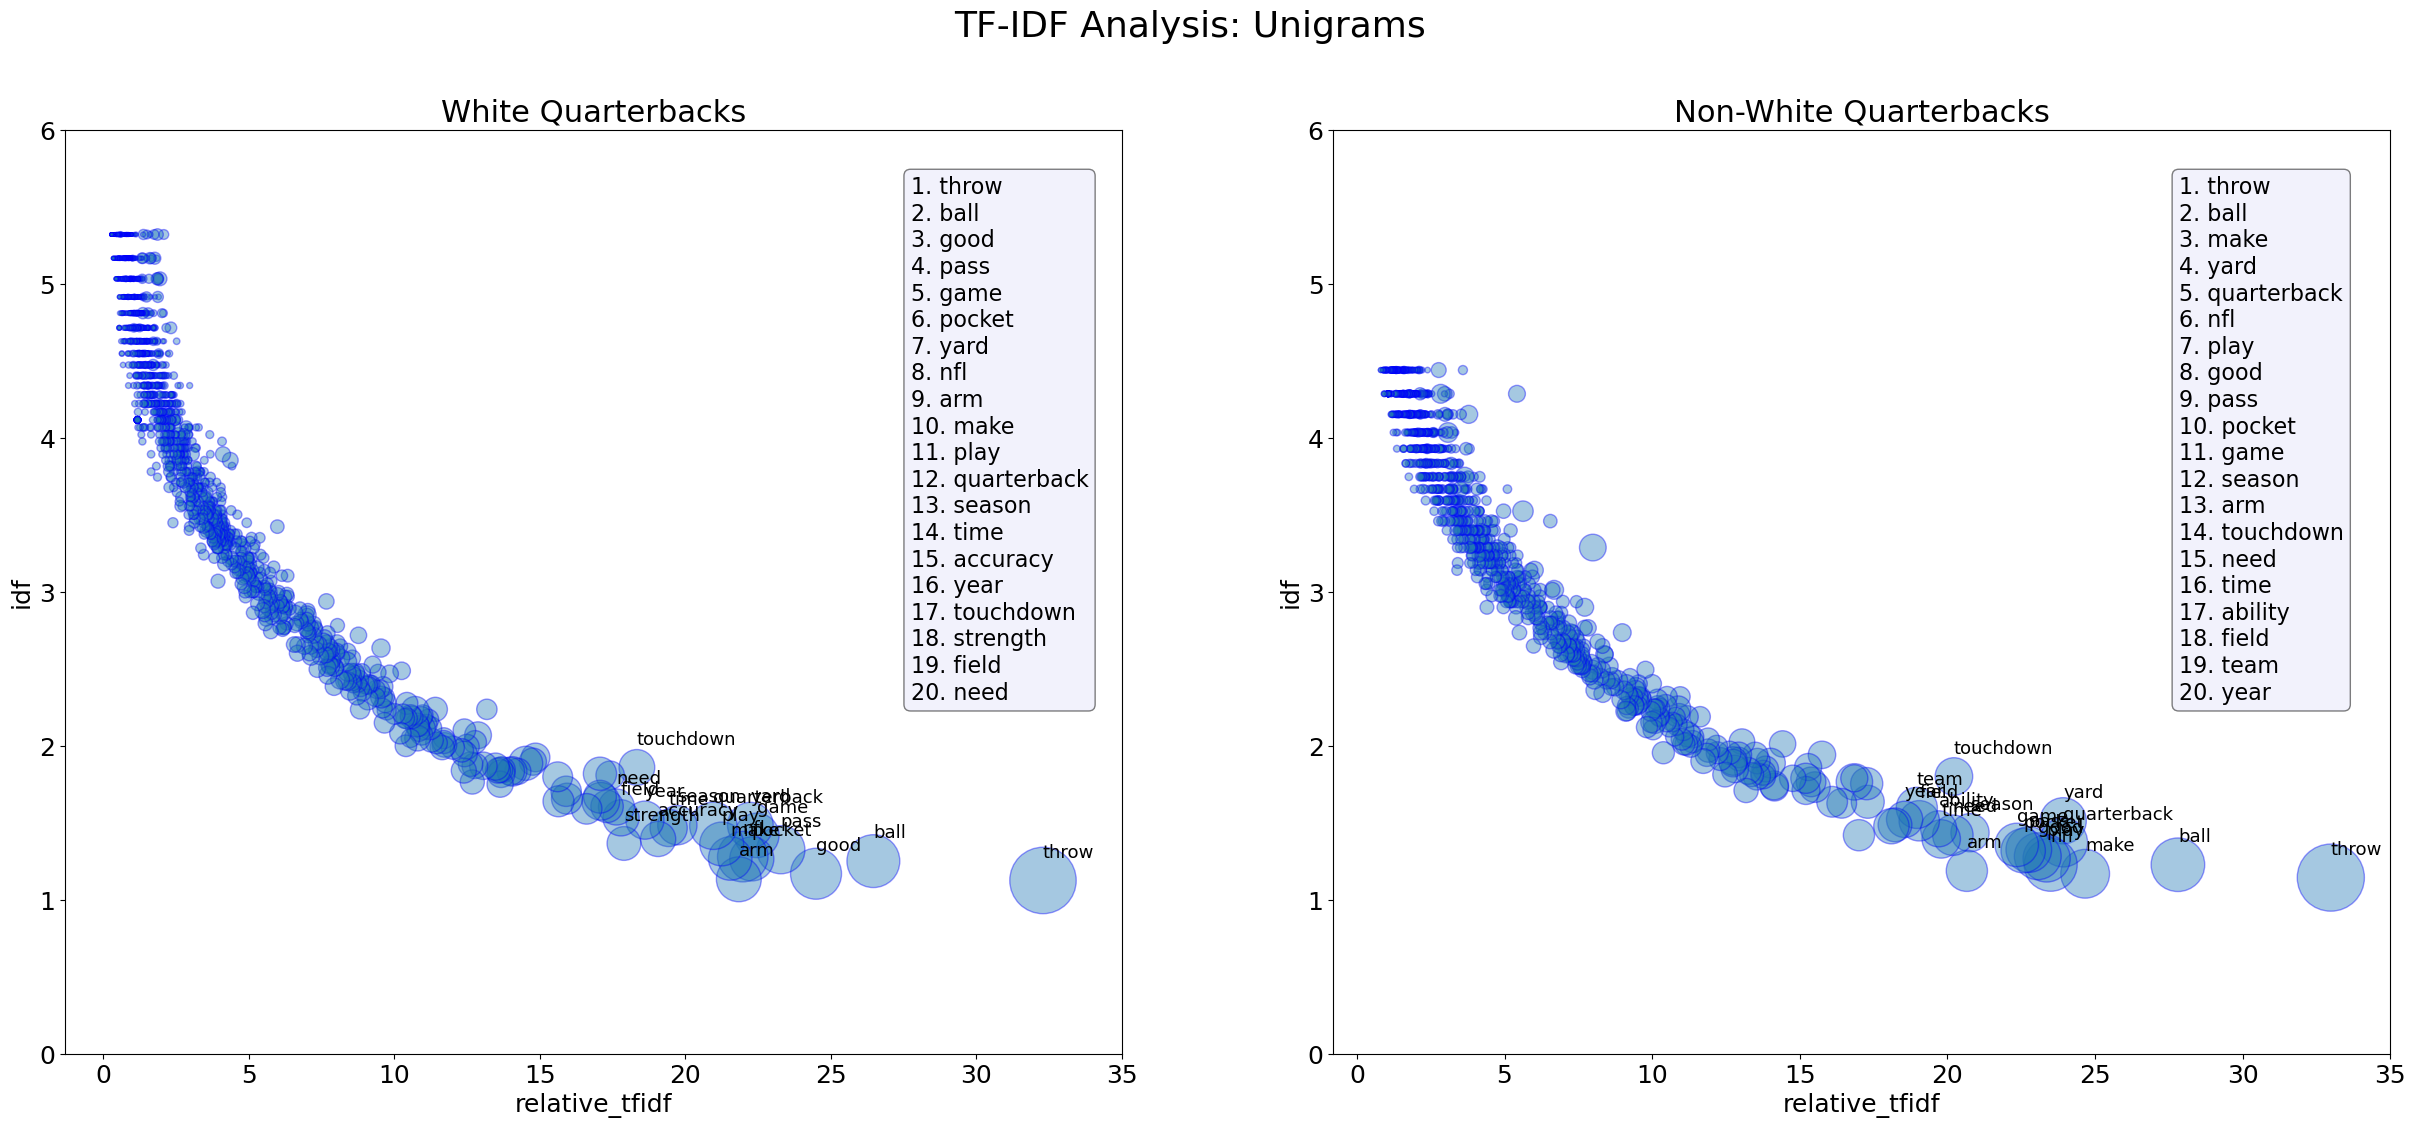

In [70]:
# Plot, with annotations for top 10

plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(1,2, figsize = (30,12))
top = 20

ax = axs[0]
ax = df_w.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.4, edgecolor = 'blue', xticks=range(0, 36, 5), yticks=range(0, 7, 1))

text = []
t = 1
for i in list(df_w.index[:top]):
    ax.annotate(df_w.word[i], (df_w.relative_tfidf[i], df_w.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_w.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('White Quarterbacks', fontsize=22)

ax = axs[1]
ax = df_nw.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.4, edgecolor = 'blue', xticks=range(0, 36, 5), yticks=range(0, 7, 1))

text = []
t = 1
for i in list(df_nw.index[:top]):
    ax.annotate(df_nw.word[i], (df_nw.relative_tfidf[i], df_nw.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_nw.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('Non-White Quarterbacks', fontsize=22)

fig.suptitle("TF-IDF Analysis: Unigrams", fontsize=26)
plt.show()

### 2.2. Bigrams

In [95]:
# Set our parameters to filter out rare words (min_df) and the too common ones (max_df), we do not want to get flooded with non-informative content words (be, go, etc.)
min_df = 3
max_df = 1000

# TF-IDF and Count for bigrams 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df, sublinear_tf=True, use_idf=True)
count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', analyzer='word', min_df=min_df, max_df=max_df)

In [96]:
# White players
X_count = count_vectorizer.fit_transform(w_docs)
X_tfidf = tfidf_vectorizer.fit_transform(w_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_w = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_w = df_w.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_w['relative_tf'] = df_w['tf'] * 100000 / df_w['tf'].sum()
df_w['relative_tfidf'] = df_w['tfidf'] * 100000 / df_w['tf'].sum()
df_w.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
279,arm strength,440,1.407685,13.383222,1080.948286,32.878570
5151,yard touchdown,382,2.055222,12.044708,938.459649,29.590243
4840,touchdown interception,306,2.141654,10.640058,751.750399,26.139436
3024,pass yard,293,2.068042,9.925671,719.813291,24.384401
902,complete percent,233,2.251655,8.871415,572.411252,21.794411


In [97]:
# Non-White players
X_count = count_vectorizer.fit_transform(nw_docs)
X_tfidf = tfidf_vectorizer.fit_transform(nw_docs)

counts = X_count.toarray()
tfidf = X_tfidf.toarray()

df_nw = pd.DataFrame(data = {'word' : count_vectorizer.get_feature_names_out(), 'tf' : counts.sum(axis=0), 'idf' : tfidf_vectorizer.idf_, 'tfidf' : tfidf.sum(axis=0)})
df_nw = df_nw.sort_values(['tfidf', 'tf', 'idf'], ascending=False)
df_nw['relative_tf'] = df_nw['tf'] * 100000 / df_nw['tf'].sum()
df_nw['relative_tfidf'] = df_nw['tfidf'] * 100000 / df_nw['tf'].sum()
df_nw.head(5)

,word,tf,idf,tfidf,relative_tf,relative_tfidf
123,arm strength,132,1.625938,6.315961,969.946359,46.410179
2146,yard touchdown,142,2.041454,5.966924,1043.427144,43.845427
2020,touchdown interception,120,2.170666,5.424111,881.769417,39.856794
1261,pass yard,102,2.120235,4.970177,749.504005,36.521249
377,complete percent,89,2.279865,4.477808,653.978984,32.903288


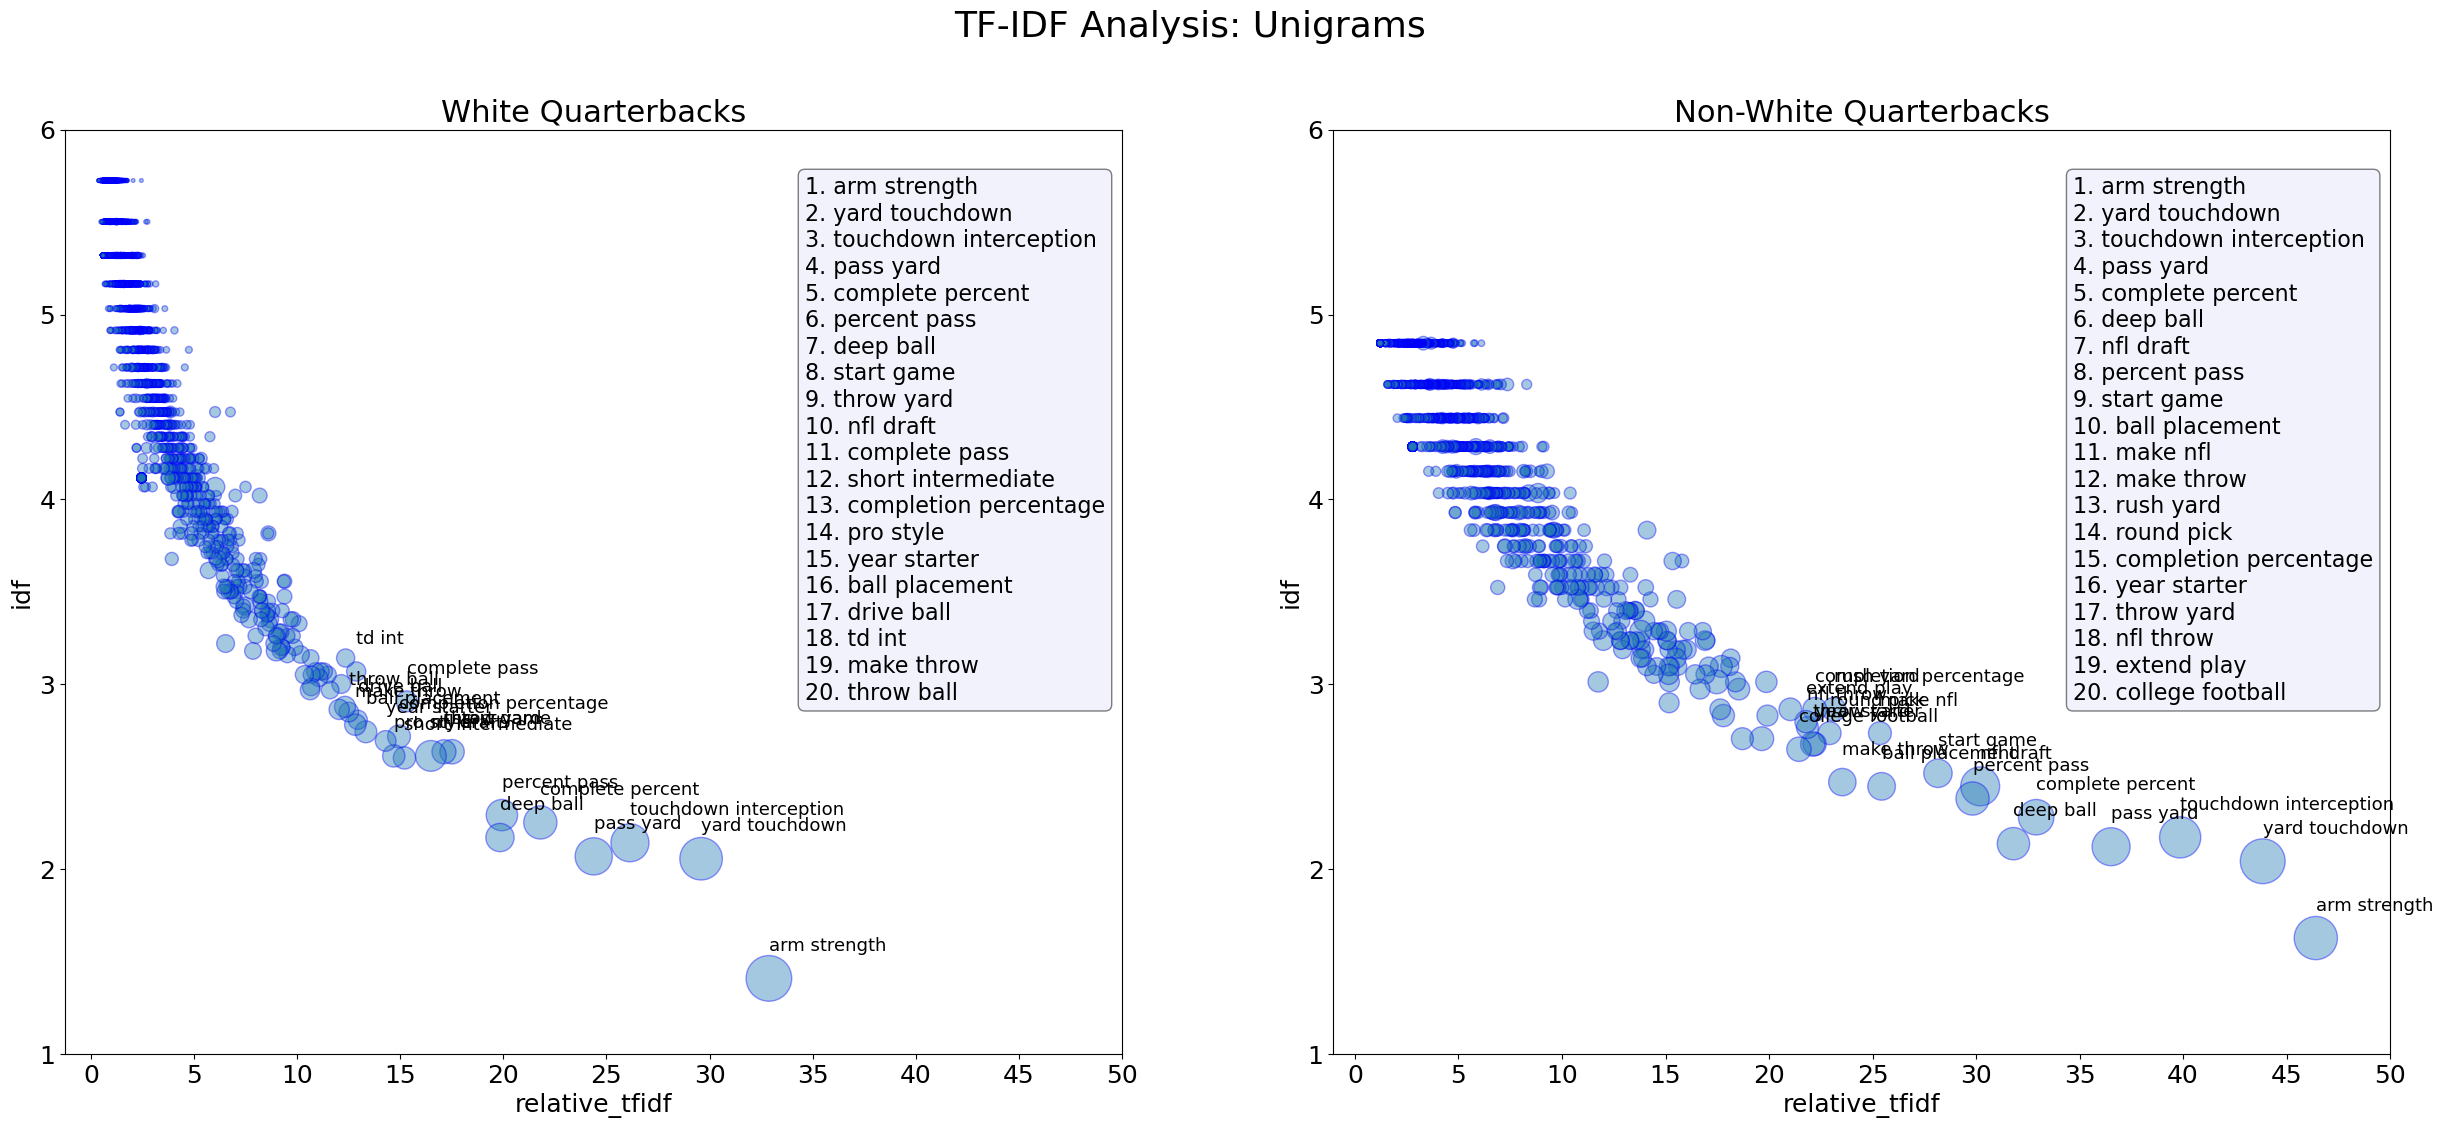

In [98]:
# Plot, with annotations for top 10

plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(1,2, figsize = (30,12))
top = 20

ax = axs[0]
ax = df_w.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.4, edgecolor = 'blue', xticks=range(0, 51, 5), yticks=range(1, 7, 1))

text = []
t = 1
for i in list(df_w.index[:top]):
    ax.annotate(df_w.word[i], (df_w.relative_tfidf[i], df_w.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_w.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.70, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('White Quarterbacks', fontsize=22)

ax = axs[1]
ax = df_nw.plot.scatter(x = 'relative_tfidf', y = 'idf', s = 'relative_tf', ax = ax, alpha = 0.4, edgecolor = 'blue', xticks=range(0, 51, 5), yticks=range(1, 7, 1))

text = []
t = 1
for i in list(df_nw.index[:top]):
    ax.annotate(df_nw.word[i], (df_nw.relative_tfidf[i], df_nw.idf[i] + 0.15), fontsize=13)
    text.append(f'{t}. {df_nw.word[i]}')
    t += 1

textstr = '\n'.join(text)
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax.text(0.70, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
ax.set_title('Non-White Quarterbacks', fontsize=22)

fig.suptitle("TF-IDF Analysis: Unigrams", fontsize=26)
plt.show()